In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from Reward_Training.rt_extension import Reward_Training
from rc_extension import Reward_Competition
from pathlib import Path


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Competition\combined_cohorts"

csv_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Competition\combined_cohorts\manual_scoring_combined.xlsx"

# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Competition\Test"

In [3]:
rc_exp = Reward_Competition(experiment_folder_path=experiment_path, behavior_folder_path=None)
rc_exp.rtc_processing()
rc_exp.read_and_merge_manual_scoring(csv_path)
rc_exp.remove_tangles()   # Remove sound cues and winner array indexes where there are tangles
rc_exp.remove_specified_subjects()   # Remove specified subjects from the analysis
rc_exp.extract_da_columns()   # Grab only essential columns for analysis
rc_exp.find_first_port_entry_after_sound_cue()
rc_exp.compute_EI_DA()
rc_exp.compute_rtc_da_metrics().head()
rc_exp.split_by_winner()

Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Competition\combined_cohorts\n5-240912-080246\Notes.txt
read from t=0s to t=2051.77s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Competition\combined_cohorts\n5-240913-094304\Notes.txt
read from t=0s to t=2044.77s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Competition\combined_cohorts\n5-240915-060250\Notes.txt
read from t=0s to t=2044.96s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Competition\combined_cohorts\n5-240915-095000\Notes.txt
read from t=0s to t=2070.66s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Reward_Competition\combined_cohorts\n7-240912-095235\Notes.txt
read from t=0s to t=1955.86s
Found Synapse note file: C:\Users\alber\

In [4]:
# 1) build your winner/loser df as before:
winner_df = rc_exp.winner_df

# 1) build your winner/loser df as before:
loser_df = rc_exp.loser_df

In [5]:
ranks = rc_exp.find_ranks_using_ds(csv_path) #david's score
df_winning = rc_exp.merging_ranks(ranks, df=winner_df)
df_losing = rc_exp.merging_ranks(ranks, df=loser_df)

In [14]:
df_winning.columns

Index(['subject_name', 'file name', 'trial', 'filtered_sound_cues',
       'filtered_port_entries', 'filtered_port_entry_offset',
       'filtered_winner_array', 'first_PE_after_sound_cue', 'Tone_Time_Axis',
       'Tone_Zscore', 'PE_Time_Axis', 'PE_Zscore', 'Tone AUC', 'Tone Max Peak',
       'Tone Time of Max Peak', 'Tone Mean Z-score', 'PE AUC', 'PE Max Peak',
       'PE Time of Max Peak', 'PE Mean Z-score', 'DS', 'Cage', 'Rank'],
      dtype='object')

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

def plot_param_by_rank_separate(df: pd.DataFrame,
                                param: str,
                                id_col: str = "subject_name",
                                rank_col: str = "Rank",
                                agg_func: str = "mean",
                                list_reduce: str = "mean",
                                figsize: tuple = (5,5),
                                marker: str = "o"):
    """
    For each brain region (mPFC, NAc), make its own figure:
      • collapse multiple runs per mouse by agg_func ('mean','median','max')
      • reduce list‐like entries via list_reduce ('mean','max','first')
      • scatter Rank (1–4) vs param, fit line, compute Pearson r & p
      • loose styling: only left+bottom spines, no grid, x‐ticks=[1,2,3,4]
    """

    df = df.copy()

    # 1) reduce any list/array entries to a single scalar
    def _reduce(v):
        if isinstance(v, (list, tuple, np.ndarray)):
            a = np.asarray(v, float).ravel()
            if list_reduce == "mean":
                return np.nanmean(a)
            elif list_reduce == "max":
                return np.nanmax(a)
            elif list_reduce == "first":
                return a[0]
            else:
                raise ValueError(f"Unknown list_reduce '{list_reduce}'")
        return v

    df[param] = df[param].apply(_reduce)

    # 2) derive brain_region if absent
    if "brain_region" not in df.columns:
        first = df[id_col].str[0].str.lower()
        df["brain_region"] = first.map({"p": "mPFC", "n": "NAc"}).fillna("unknown")

    # 3) collapse runs per subject
    grp = [id_col, "brain_region", rank_col]
    if agg_func == "mean":
        collapsed = df.groupby(grp)[param].mean().reset_index()
    elif agg_func == "median":
        collapsed = df.groupby(grp)[param].median().reset_index()
    elif agg_func == "max":
        collapsed = df.groupby(grp)[param].max().reset_index()
    else:
        raise ValueError("agg_func must be 'mean','median' or 'max' ")

    # 4) loop regions and make separate figs
    colors = {"mPFC": "#FFAF00", "NAc": "#15616F"}
    for region in ["mPFC", "NAc"]:
        sub = collapsed[collapsed["brain_region"] == region].copy()
        if sub.empty:
            print(f"— no data for {region}, skipping.")
            continue

        sub = sub.sort_values(by=rank_col)
        fig, ax = plt.subplots(figsize=figsize)

        # scatter
        ax.scatter(sub[rank_col], sub[param],
                   s=80, marker=marker,
                   color=colors[region], edgecolor="k")

        # linear fit
        if len(sub) >= 2:
            m, b = np.polyfit(sub[rank_col], sub[param], 1)
            xs = np.array([1,4])
            ax.plot(xs, m*xs + b, color="k", lw=1)

        # Pearson
        try:
            r, p = pearsonr(sub[rank_col], sub[param])
        except ValueError:
            r, p = np.nan, np.nan

        # annotate
        txt = f"r = {r:.2f}\np = {p:.3f}\nn = {len(sub)}"
        ax.text(0.05, 0.95, txt,
                transform=ax.transAxes,
                va="top", ha="left",
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"))

        # styling
        ax.set_title(f"{region}: {param} vs. Rank")
        ax.set_xlabel("Rank")
        ax.set_ylabel(param)
        ax.set_xticks([1,2,3,4])
        ax.set_xlim(0.8, 4.2)
        ax.grid(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        plt.tight_layout()
        plt.show()


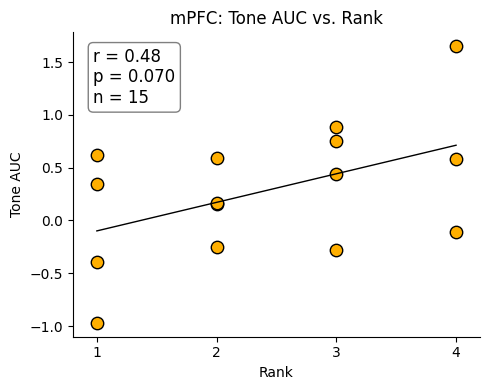

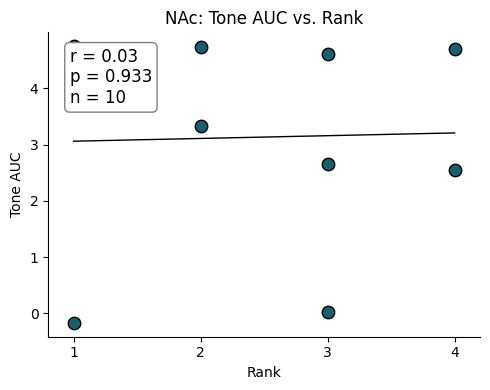

In [35]:
plot_param_by_rank_separate(
    df_winning,
    param="Tone AUC",
    id_col="subject_name",
    rank_col="Rank",
    agg_func="mean",
    list_reduce="mean",
    figsize=(5,4)
)


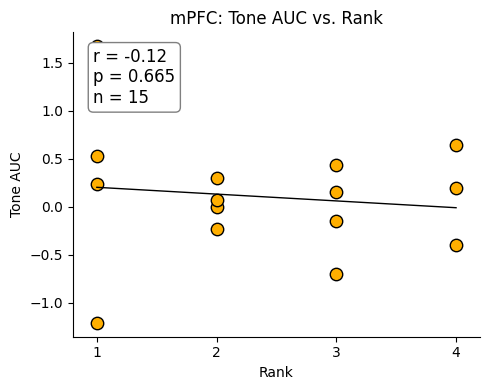

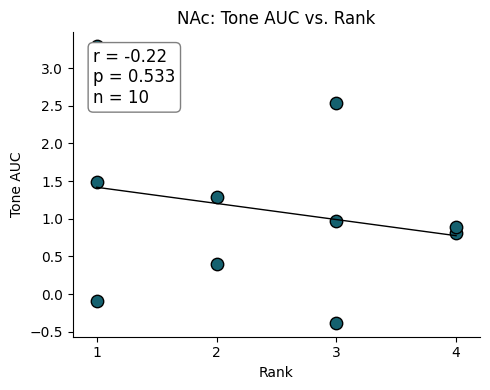

In [36]:
plot_param_by_rank_separate(
    df_losing,
    param="Tone AUC",
    id_col="subject_name",
    rank_col="Rank",
    agg_func="mean",
    list_reduce="mean",
    figsize=(5,4)
)


C:\Users\alber\AppData\Local\Temp\ipykernel_55304\1541126229.py:29: RuntimeWarning: Mean of empty slice
  return np.nanmean(a)


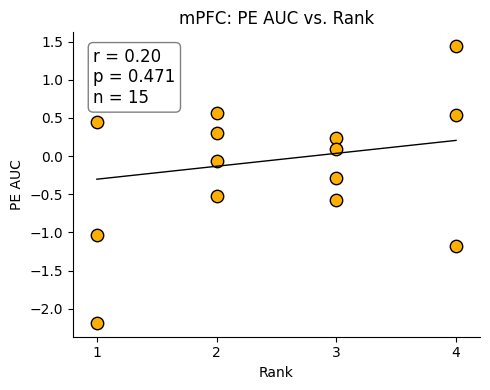

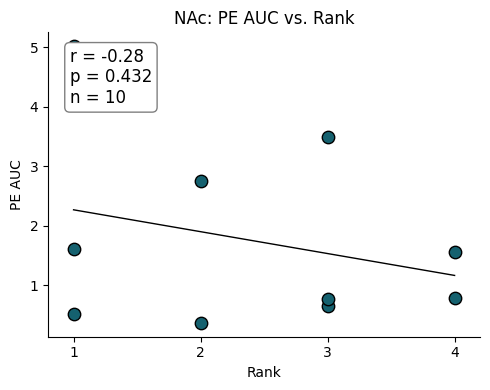

In [44]:
plot_param_by_rank_separate(
    df_losing,
    param="PE AUC",
    id_col="subject_name",
    rank_col="Rank",
    agg_func="mean",
    list_reduce="mean",
    figsize=(5,4)
)


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

def plot_param_by_rank_with_mouse_legend(df: pd.DataFrame,
                                         param: str,
                                         id_col: str = "subject_name",
                                         rank_col: str = "Rank",
                                         agg_func: str = "mean",
                                         list_reduce: str = "mean",
                                         figsize: tuple = (6,6),
                                         marker: str = "o"):
    """
    Like plot_param_by_rank_separate, but colors each mouse (subject_name) separately
    and shows a legend mapping color → mouse.
    """
    df = df.copy()

    # 1) reduce list‐like entries
    def _reduce(v):
        if isinstance(v, (list, tuple, np.ndarray)):
            a = np.asarray(v, float).ravel()
            if list_reduce == "mean":
                return np.nanmean(a)
            elif list_reduce == "max":
                return np.nanmax(a)
            elif list_reduce == "first":
                return a[0]
            else:
                raise ValueError(f"Unknown list_reduce '{list_reduce}'")
        return v

    df[param] = df[param].apply(_reduce)

    # 2) derive brain_region if absent
    if "brain_region" not in df.columns:
        first = df[id_col].str[0].str.lower()
        df["brain_region"] = first.map({"p": "mPFC", "n": "NAc"}).fillna("unknown")

    # 3) collapse multiple runs per subject
    grp = [id_col, "brain_region", rank_col]
    if agg_func == "mean":
        collapsed = df.groupby(grp)[param].mean().reset_index()
    elif agg_func == "median":
        collapsed = df.groupby(grp)[param].median().reset_index()
    elif agg_func == "max":
        collapsed = df.groupby(grp)[param].max().reset_index()
    else:
        raise ValueError("agg_func must be 'mean','median' or 'max'")

    # 4) for each region, assign each subject a distinct color
    regions = ["mPFC", "NAc"]
    for region in regions:
        sub = collapsed[collapsed["brain_region"] == region]
        if sub.empty:
            continue

        subjects = sorted(sub[id_col].unique())
        # pick a palette large enough
        palette = plt.get_cmap("tab10")
        colors = {s: palette(i % 10) for i, s in enumerate(subjects)}

        fig, ax = plt.subplots(figsize=figsize)

        # scatter each mouse
        for subj in subjects:
            df_subj = sub[sub[id_col] == subj].sort_values(by=rank_col)
            ax.scatter(df_subj[rank_col],
                       df_subj[param],
                       s=80,
                       marker=marker,
                       color=colors[subj],
                       edgecolor="k",
                       label=subj)

        # linear fit across all points in this region
        if len(sub) >= 2:
            m, b = np.polyfit(sub[rank_col], sub[param], 1)
            xs = np.array([1,4])
            ax.plot(xs, m*xs + b, color="k", lw=1)

        # Pearson
        try:
            r, p = pearsonr(sub[rank_col], sub[param])
        except Exception:
            r, p = np.nan, np.nan
        txt = f"r = {r:.2f}\np = {p:.3f}\nn = {len(subjects)}"
        ax.text(0.05, 0.95, txt,
                transform=ax.transAxes, va="top", ha="left",
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"))

        # styling
        ax.set_title(f"{region}: {param} vs. Rank")
        ax.set_xlabel("Rank")
        ax.set_ylabel(param)
        ax.set_xticks([1,2,3,4])
        ax.set_xlim(0.8, 4.2)
        ax.grid(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # legend outside
        ax.legend(title="Subject", bbox_to_anchor=(1.05,1), loc="upper left")

        plt.tight_layout()
        plt.show()


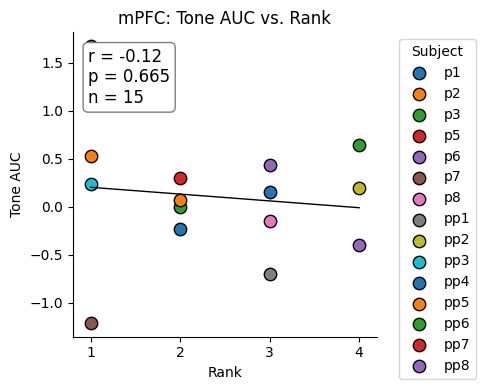

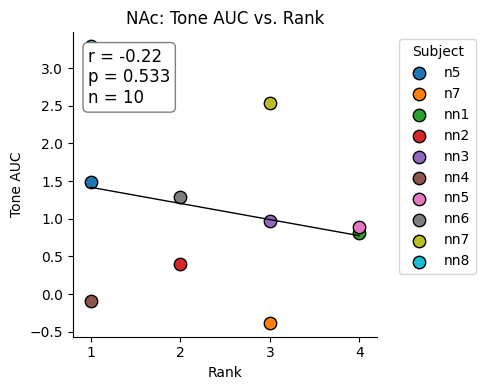

In [41]:
plot_param_by_rank_with_mouse_legend(
    df_losing,
    param="Tone AUC",
    id_col="subject_name",
    rank_col="Rank",
    agg_func="mean",
    list_reduce="mean",
    figsize=(5,4)
)
